<h1 style="font-size:3rem;color:orange;">Predicting Loan E-Signatures 🖆</h1>

<h2 style="font-size:2rem;color:orange;">Data Pre-processing and Model Building</h2>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os
import pandas as pd

In [2]:
import warnings

# Optionally suppress warnings from libraries due to changes in the Python ecosystem
warnings.filterwarnings(action='ignore', module='_distutils_hack', category=UserWarning)
warnings.filterwarnings(action='ignore', module='setuptools', category=UserWarning)

### Import Data

In [3]:
df_users_financial = pd.read_csv("../data/processed/new_P39-Financial-Data.csv")

### Data Peek 👀

In [4]:
df_users_financial.head()

,entry_id,age,monthly_income,years_employed,current_address_year,amount_requested,risk_score,inquiries_last_month,pay_schedule,home_owner,has_debt,personal_account_months,avg_risk_score,avg_ext_quality_score,e_signed
0,7629673,40,3135,3,3,550,36200,10,bi-weekly,1,1,30,0.661151,0.480918,1
1,3560428,61,3180,6,3,600,30150,9,weekly,0,1,86,0.789841,0.680720,0
2,6934997,23,1540,0,0,450,34550,7,weekly,0,1,19,0.691712,0.531712,0
3,5682812,40,5230,6,1,700,42150,8,bi-weekly,0,1,86,0.793179,0.692552,1
4,5335819,33,3590,5,2,1100,53850,12,semi-monthly,0,1,98,0.688483,0.744634,0


In [5]:
df_users_financial.describe()

,entry_id,age,monthly_income,years_employed,current_address_year,amount_requested,risk_score,inquiries_last_month,home_owner,has_debt,personal_account_months,avg_risk_score,avg_ext_quality_score,e_signed
count,1.790800e+04,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000
mean,5.596978e+06,43.015412,3657.214653,3.526860,3.584711,950.446449,61086.302211,6.457226,0.425173,0.795399,45.467389,0.717640,0.622590,0.538251
std,2.562473e+06,11.873107,1504.890063,2.259732,2.751937,698.543683,15394.255020,3.673093,0.494383,0.403421,23.258829,0.070536,0.115284,0.498549
min,1.111398e+06,18.000000,905.000000,0.000000,0.000000,350.000000,2100.000000,1.000000,0.000000,0.000000,0.000000,0.353661,0.022057,0.000000
25%,3.378999e+06,34.000000,2580.000000,2.000000,2.000000,600.000000,49350.000000,4.000000,0.000000,1.000000,29.000000,0.668689,0.547725,0.000000
50%,5.608376e+06,42.000000,3260.000000,3.000000,3.000000,700.000000,61200.000000,6.000000,0.000000,1.000000,40.000000,0.719793,0.627009,1.000000
75%,7.805624e+06,51.000000,4670.000000,5.000000,5.000000,1100.000000,72750.000000,8.000000,1.000000,1.000000,54.000000,0.769095,0.702689,1.000000
max,9.999874e+06,96.000000,9985.000000,16.000000,12.000000,10200.000000,99750.000000,30.000000,1.000000,1.000000,183.000000,0.925252,0.966953,1.000000


- Above we note that we currently have 17,908 samples for model training and evaluation
- With 12 numerical & categorical features combined

# Data Pre-processing 🧹

### Remove the label from the features

In [6]:
label = df_users_financial['e_signed']
df_users_financial = df_users_financial.drop(columns = 'e_signed')

### One-Hot Encoding 

In [7]:
# One-hot encoding of 'pay_schedule'
df_users_financial_ohe = pd.get_dummies(df_users_financial)

### Transformations

In [8]:
# Take the log of 'amount_requested' to address remaining skew
df_users_financial_ohe['log_amount_requested'] = np.log(df_users_financial_ohe['amount_requested'])

# Drop the previous values 
df_users_financial_ohe.drop('amount_requested', axis=1, inplace=True)

### Split the dataset into training and test sets

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into an 80/20 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(df_users_financial_ohe, label, test_size = 0.2, stratify=label, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(14326, 17)
(3582, 17)


### Filter model data

In [10]:
# Purge user identification, persist to associate the prediction to the user it came from 
user_identification = 'entry_id'

train_identifier = X_train[user_identification]
X_train = X_train.drop(columns = [user_identification])

test_identifier = X_test[user_identification]
X_test = X_test.drop(columns = [user_identification])

### Feature Scaling

In [11]:
from sklearn.preprocessing import StandardScaler

def standard_scale(your_df):
    # Identify columns to be excluded from scaling
    excluded_columns = [col for col in your_df.columns if any(substring in col for substring in ['pay_schedule_', 'has_', 'home_'])]

    # Columns to be standardized
    columns_to_scale = [col for col in your_df.columns if col not in excluded_columns]

    # Instantiate the scaler
    standard_scaler_X = StandardScaler()

    # Scale the non-binary columns
    scaled_features = standard_scaler_X.fit_transform(your_df[columns_to_scale])

    # Convert scaled features into DataFrame
    scaled_df = pd.DataFrame(scaled_features, columns=columns_to_scale, index=your_df.index)

    # Concatenate the scaled features with the binary columns to get the final dataframe
    your_df = pd.concat([scaled_df, your_df[excluded_columns]], axis=1)

    return your_df

X_train = standard_scale(X_train)
X_test = standard_scale(X_test)

X_train.head()

,age,monthly_income,years_employed,current_address_year,risk_score,inquiries_last_month,personal_account_months,avg_risk_score,avg_ext_quality_score,log_amount_requested,home_owner,has_debt,pay_schedule_bi-weekly,pay_schedule_monthly,pay_schedule_semi-monthly,pay_schedule_weekly
10137,0.080725,2.917931,-0.675720,-0.210497,2.191775,-0.393958,-1.952904,-0.989248,-0.806010,2.548321,1,1,False,True,False,False
13252,-0.339352,0.988315,-1.117948,-0.939249,-0.668276,-0.122554,-0.364336,0.290367,-1.165044,-1.320879,0,1,True,False,False,False
15959,0.164741,-0.657182,-0.675720,0.153879,0.058086,-0.936766,-0.836613,-0.187749,-0.491509,0.590583,0,0,True,False,False,False
16002,-0.003290,-0.598628,-0.233492,-0.939249,-0.152689,-0.665362,-0.364336,-0.326733,-1.796702,0.754995,0,0,True,False,False,False
16215,0.332772,0.948392,0.208735,-0.574873,-1.456249,0.148850,0.322612,1.501842,-0.023514,0.211408,1,1,False,False,False,True


# Model Building 🤖

### Training Data

In [12]:
# Split the training set into a 80/20 training/validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print(X_train.shape)
print(X_validation.shape)

(11460, 16)
(2866, 16)


### Metrics Function

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_scores_and_concat(y_test, y_predict, model_name, results_dataframe): 
    """
    Evaluates model scores and concatenates results to a DataFrame.
    """
    # Get scores
    accuracy = accuracy_score(y_test, y_predict)   # CorrectPredicts / TotalPredicts  
    precision = precision_score(y_test, y_predict) # TP / (TP+FP)
    recall = recall_score(y_test, y_predict)       # TP / (TP+FN)
    f1 = f1_score(y_test, y_predict)               # 2*(precision*recall) / (precision+recall)
    
    # Transfer scores to a DataFrame
    new_results = pd.DataFrame([[model_name, accuracy, precision, recall, f1]],
            columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
    
    # Concatenate results to the results_dataframe vertically
    results_dataframe = pd.concat([results_dataframe, new_results], axis=0).reset_index(drop=True)
    
    return results_dataframe

## Logistic Regression 📈

### Training

In [14]:
from sklearn.linear_model import LogisticRegression

# Add 'l1' penalty (lasso regularization)
model = LogisticRegression(penalty='l1', solver='saga', random_state=42)

model.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='saga')

### Evaluation

In [15]:
# Make predictions from the validation set
y_predict = model.predict(X_validation)

# Initialize a results DataFrame
df_results = pd.DataFrame()

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'Logistic Regression (Lasso)', df_results)

# Display
df_results.head()

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.571877,0.582896,0.720026,0.644245


## Support Vector Machines 🛤️

### SVC (Linear) Training

In [16]:
from sklearn.svm import SVC

# Add linear kernel
model = SVC(kernel='linear', random_state=42)

model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

### SVC (Linear) Evaluation

In [17]:
# Make predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'SVC (Linear)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.571877,0.582896,0.720026,0.644245
1,SVC (Linear),0.576064,0.584189,0.737524,0.651962


### SVC (RBF) Training

In [18]:
# Radial Basis Function kernel (default)
model = SVC(kernel='rbf', random_state=42)

model.fit(X_train, y_train)

SVC(random_state=42)

### SVC (RBF) Evaluation

In [19]:
# Make predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'SVC (RBF)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.571877,0.582896,0.720026,0.644245
1,SVC (Linear),0.576064,0.584189,0.737524,0.651962
2,SVC (RBF),0.612003,0.619656,0.723266,0.667464


## Random Forest Classifier 🌳

### Training

In [20]:
from sklearn.ensemble import RandomForestClassifier

# 100 trees
model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

### Evaluation

In [21]:
# Make predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'Random Forest Classifier (n=100)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.571877,0.582896,0.720026,0.644245
1,SVC (Linear),0.576064,0.584189,0.737524,0.651962
2,SVC (RBF),0.612003,0.619656,0.723266,0.667464
3,Random Forest Classifier (n=100),0.624564,0.641945,0.684381,0.662484


## XGBoost Classifier 🚀 

### Training

In [22]:
from xgboost import XGBClassifier

# 100 stages (trees)
model = XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Evaluation

In [23]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'XGBoost Classifier (n=100)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.571877,0.582896,0.720026,0.644245
1,SVC (Linear),0.576064,0.584189,0.737524,0.651962
2,SVC (RBF),0.612003,0.619656,0.723266,0.667464
3,Random Forest Classifier (n=100),0.624564,0.641945,0.684381,0.662484
4,XGBoost Classifier (n=100),0.621075,0.639927,0.677252,0.658060


## Gradient Boosting Classifier 🚀 

### Training

In [24]:
from sklearn.ensemble import GradientBoostingClassifier 

# 100 stages (trees)
model = GradientBoostingClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### Evaluation

In [25]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'Gradient Boosting Classifier (n=100)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.571877,0.582896,0.720026,0.644245
1,SVC (Linear),0.576064,0.584189,0.737524,0.651962
2,SVC (RBF),0.612003,0.619656,0.723266,0.667464
3,Random Forest Classifier (n=100),0.624564,0.641945,0.684381,0.662484
4,XGBoost Classifier (n=100),0.621075,0.639927,0.677252,0.658060
5,Gradient Boosting Classifier (n=100),0.627355,0.640284,0.702528,0.669963


## Save Data 💾

In [26]:
# Create a directory to save results if it doesn't exist
directory = "../experiments"
if not os.path.exists(directory):
    os.makedirs(directory)

df_results.to_csv("../experiments/baseline_metrics.csv", index = False)

## Baseline Model Evaluation <img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExNDM1bWRnOW05MW9nNW1kNXJqbDNlMnRpMjFwZ2hpMHJuaWZ2Nms0eSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9cw/ZOKhyP4ai1guMHhwFB/giphy.gif" width="44" alt="Stat Bars">

Above we discover that the Gradient Boosting Classifier (GBC) has provided some our best estimates thus far as a baseline model and continue with a further evaluation of the model

### Confusion Matrix

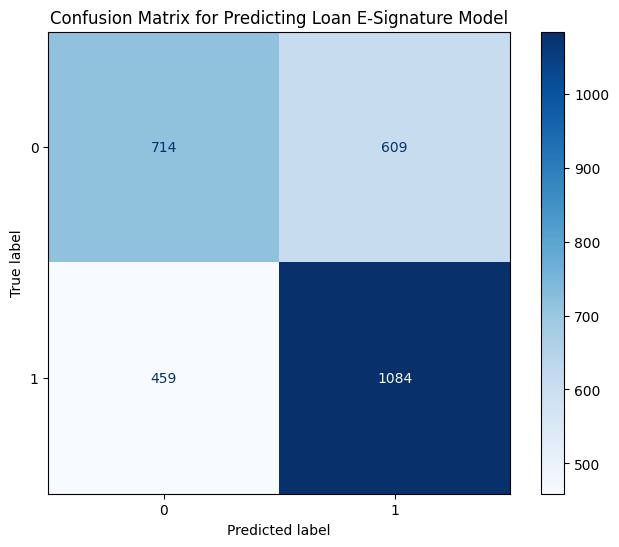

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def sklearn_confusion_matrix(y_test, y_predict):
  """
  Generates a simple confusion matrix. 
  Accepts the test set and the predicted labels from the model.
  """
  # Create a confusion matrix with the validation labels and our model's predictions
  conf_matrix = confusion_matrix(y_test, y_predict)

  # Create the plot
  fig, ax = plt.subplots(figsize=(8,6), dpi=100)
  display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
  ax.set(title='Confusion Matrix for Predicting Loan E-Signature Model')
  display.plot(ax=ax, cmap='Blues', values_format='d')
  plt.show()
  
sklearn_confusion_matrix(y_validation, y_predict)

### Combine Train and Validation Data for Cross-Validation

In [28]:
# Concatenate the training and validation feature datasets vertically
X_train_and_validation = pd.concat([X_train, X_validation], axis=0).reset_index(drop=True)

# Concatenate the training and validation label datasets vertically
y_train_and_validation = pd.concat([y_train, y_validation], axis=0).reset_index(drop=True)

### K-Fold Cross Validation

Estimate how well the model is likely to generalize to unseen data

In [29]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Accuracy is {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval is +- {:.2f}%\n".format((accuracies.std()*2)*100))
print(accuracies)

Accuracy is 63.62%
Confidence Interval is +- 1.63%

[0.64619679 0.63084438 0.64480112 0.63154222 0.63293789 0.64131193
 0.61731844 0.64315642 0.63687151 0.63687151]


### Receiver Operating Characteristic (ROC) Curve

AUC (Area Under the ROC Curve): 0.69


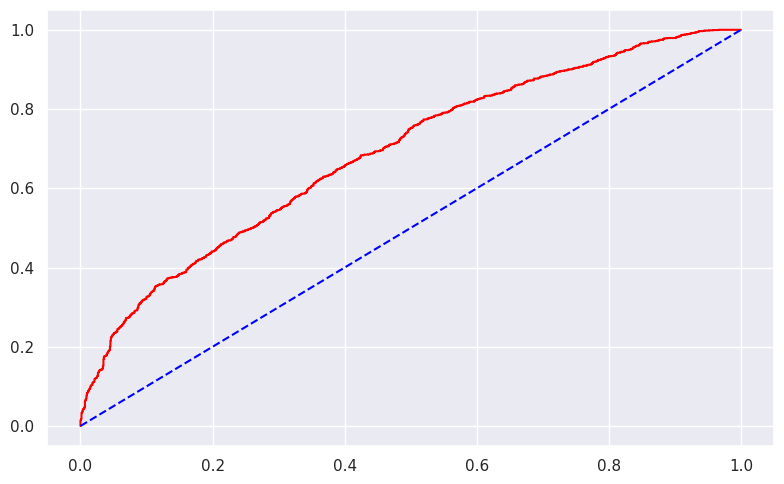

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn.objects as so

def plot_roc_curve(X_test, y_test, model):
   """
   Function for plotting an ROC Curve.
   Accepts the test features and labels.
   Returns a plot and the AUC. 
   """
   # Generate data for a 45 degree line
   noskill_probabilities = [0 for number in range(len(y_test))]

   # Predict the probabilities of the positive class
   probabilities_posclass = model.predict_proba(X_test)[:, 1]

   # Calculate data for horizontal line
   falsepositive_rate_noskill, truepositive_rate_noskill, _ = roc_curve(y_test, noskill_probabilities)

   # Calculate data for ROC curve
   falsepositive_rate, truepositive_rate, _ = roc_curve(y_test, probabilities_posclass)

   # Calculate AUC
   auc = roc_auc_score(y_test, probabilities_posclass)

   # Display AUC
   print("AUC (Area Under the ROC Curve): {:.2f}".format(auc))

   # Plot with Seaborn Objects
   plt = (so.Plot()
      .add(so.Line(color = 'red'),x =falsepositive_rate, y = truepositive_rate)
      .add(so.Line(color = 'blue',linestyle = 'dashed'),x = falsepositive_rate_noskill, y = truepositive_rate_noskill)
      .layout(size = (8,5))
      )
   
   plt.show()
   
   return auc

# Call the function
auc_score = plot_roc_curve(X_validation, y_validation, model)

The model's discriminatory power is somewhat less than reasonable and we aim to improve this score via hyperparameter optimization

### Feature Significance

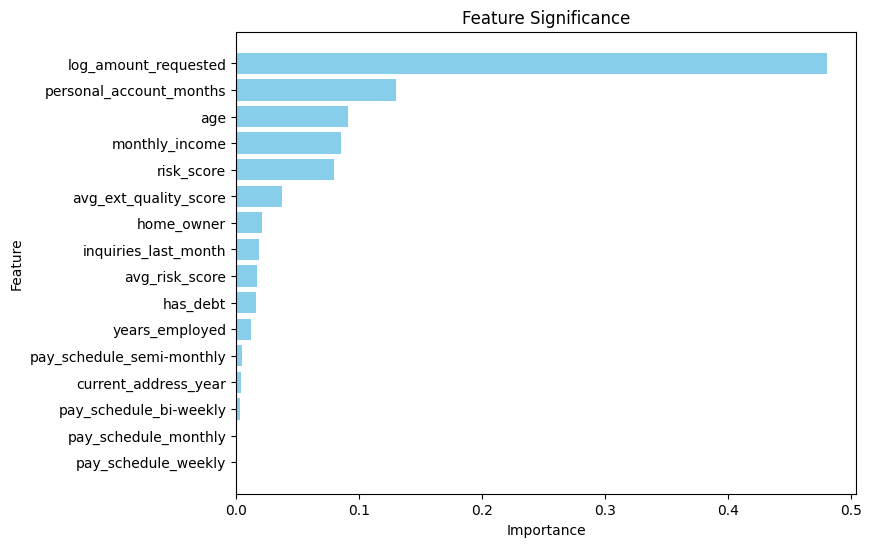

,Feature,Importance
9,log_amount_requested,0.480026
6,personal_account_months,0.129750
0,age,0.091056
1,monthly_income,0.085560
4,risk_score,0.079363
8,avg_ext_quality_score,0.037212
10,home_owner,0.021076
5,inquiries_last_month,0.018929
7,avg_risk_score,0.016706
11,has_debt,0.016028


In [31]:
def plot_feature_significance(X_train, model):
    """
    Function to plot feature significance.
    Accepts the training data and the model used to make predictions.
    """
    # Extract feature names from the DataFrame
    features = X_train.columns.tolist()

    # Create a DataFrame with feature names and their importance
    feature_df = pd.DataFrame({
      'Feature': features,
      'Importance': model.feature_importances_
      })

    # Sort the DataFrame by importance in descending order
    feature_df = feature_df.sort_values(by='Importance', ascending=False)

    # Plotting
    plt.figure(figsize=(8, 6)) 
    plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Significance')
    plt.gca().invert_yaxis()  # Place highest importantance at top
    plt.show()

    return feature_df

# Call the function
feature_df = plot_feature_significance(X_train, model)
feature_df

## Model Tuning 🎯

Here we utilize Hyperopt for model tuning to take advantage of Bayesian Optimization. Since we will not be using a Spark cluster, we will forgo using SparkTrials to parallelize trials.

We begin by initializing MLflow to document our [experiment](../experiments/README.md) 🧪

In [32]:
# Define & ensure a directory exists to save the experiment
experiment_dir = '../experiments/mlflow_gbc'
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [33]:
import random

# Use the directory to save results
mlflow.set_tracking_uri(f'file://{os.path.abspath(experiment_dir)}')

# 5 digit random number for the experiment
random_number = random.randint(10_000, 99_999)

# Set a new experiment
mlflow.set_experiment(f'hyperopt_tuning_{random_number}')

# Fetch experiment details
experiment = mlflow.get_experiment_by_name(f'hyperopt_tuning_{random_number}')

# Display details with the relative path
print(f"<Experiment: artifact_location='file://{experiment_dir}/{experiment.experiment_id}', "
      f"creation_time={experiment.creation_time}, experiment_id='{experiment.experiment_id}', "
      f"last_update_time={experiment.last_update_time}, lifecycle_stage='{experiment.lifecycle_stage}', "
      f"name='{experiment.name}', tags={experiment.tags}>")

2023/10/30 03:10:07 INFO mlflow.tracking.fluent: Experiment with name 'hyperopt_tuning_51489' does not exist. Creating a new experiment.


<Experiment: artifact_location='file://../experiments/mlflow_gbc/914547611664159153', creation_time=1698649807982, experiment_id='914547611664159153', last_update_time=1698649807982, lifecycle_stage='active', name='hyperopt_tuning_51489', tags={}>



- Define the objective function

In [34]:
from hyperopt import STATUS_OK

# Define a variable to keep track of the best model accuracy
best_accuracy_so_far = 0.00

def objective_function(space):
    """
    The objective function for Hyperopt. 
    Accepts the hyperparameter search space & returns the model accuracy. 
    Logs metadata & the model from best trials.
    """
    global best_accuracy_so_far
    
    # Convert floats to integers for the model as needed
    space['n_estimators'] = int(space['n_estimators'])
    space['max_depth'] = int(space['max_depth'])
    space['min_samples_split'] = int(space['min_samples_split'])
    space['min_samples_leaf'] = int(space['min_samples_leaf'])
    
    model = GradientBoostingClassifier(**space, random_state=42)
    
    accuracies = cross_val_score(model, X_train_and_validation, y_train_and_validation, cv = 3)
    
    # Calculate the mean & loss variance from cross validation scores
    accuracy = np.mean(accuracies)
    loss_variance = np.var(accuracies, ddof=1)
    
    # Log metadata & models with MLflow for best trials
    if accuracy > best_accuracy_so_far:
        best_accuracy_so_far = accuracy
        with mlflow.start_run():
            mlflow.log_params(space)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("loss_variance", loss_variance)
            mlflow.sklearn.log_model(model, "model")
            mlflow.end_run()
    
    # Here we aim to maximize accuracy, thus return it as a negative value
    return {'loss': -accuracy, 'loss_variance': loss_variance, 'status': STATUS_OK}

- Define the search space

In [35]:
from hyperopt import hp

search_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 8, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.02), np.log(0.035)),
    'subsample': hp.uniform('subsample', 0.7, 0.9),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    }

- Run Hyperopt. _For optimal (or fastest) results, see [suggested formulas](https://www.databricks.com/blog/2021/04/15/how-not-to-tune-your-model-with-hyperopt.html). This will take some time, go have some tea_ 

In [36]:
from hyperopt import fmin, tpe, Trials

# Demo number of trials, adjust for utilization
num_evals = 6
trials = Trials()

best_hyperparam = fmin(fn=objective_function, 
                       space=search_space, 
                       algo=tpe.suggest, # Bayesian search
                       max_evals=num_evals, 
                       trials=trials, 
                       rstate=np.random.default_rng(42)
                       ) 

print(best_hyperparam)

100%|██████████| 6/6 [00:46<00:00,  7.74s/trial, best loss: -0.6383491921503971]
{'learning_rate': 0.022443032337951682, 'max_depth': 6.0, 'max_features': 2, 'min_samples_leaf': 7.0, 'min_samples_split': 7.0, 'n_estimators': 140.0, 'subsample': 0.7807555340523958}


#### MLflow Functions

In [37]:
def get_best_scoring_model(metric_type, ascending_boolean, experiment_dir, experiment_ID):
    """
    Returns a model with the best scoring metric from MLflow.
    Accepts the metric name, an ascending order boolean (False = Higher Scores, True = Lower Scores),
    a local path to the experiment directory, the experiment_id, and experiment name.
    Returns the model with the best metric from MLflow. 
    """
    # Provide the path to directory hosting the experiment (defined above)
    mlflow.set_tracking_uri(f'file://{os.path.abspath(experiment_dir)}')

    # Provide the experiment_id (active experiment 'experiment.experiment_id' or insert manually)
    experiment_id = experiment_ID

    # Get the runs from the experiment
    runs = mlflow.search_runs(experiment_ids=[experiment_id], filter_string='', max_results=1000)

    # Filter the runs for best desired metric
    best_run = runs.sort_values(f"metrics.{metric_type}", ascending=ascending_boolean).iloc[0]

    # Provide the URI
    best_model_uri = best_run["artifact_uri"] + "/model"
    
    # Modify this line to your flavor of model: sklearn, spark, xgboost, pytorch, tensorflow, etc.
    model = mlflow.sklearn.load_model(best_model_uri)
    
    # Display model info
    print("Best Scoring Run ID:", best_run.run_id)
    print("Model Type:", type(model).__name__)
    print("Hyperparameters: ", model.get_params())
    
    return model

In [38]:
def get_model(model_dir,run_id):
    """
    Returns a model logged with MLflow.
    Accepts the path to the model, run_id, and model flavor.
    """
    # Path to the directory hosting the MLflow experiment 
    mlflow.set_tracking_uri(f'file://{os.path.abspath(model_dir)}')

    # Specify model URI
    model_uri = f"runs:/{run_id}/model" 

    # Modify this line to your flavor of model: sklearn, spark, xgboost, pytorch, tensorflow, etc.
    model = mlflow.sklearn.load_model(model_uri)
    
    return model

### K-Fold Cross Validation

Evaluate the tuned model across a more thorough cross-validation process

In [39]:
# Active experiment: experiment.experiment_id
experiment_ID = "471826949328499785"

# Load the best scoring model from the experiment (modify params as needed)
model = get_best_scoring_model("accuracy", False, experiment_dir, experiment_ID)

Best Scoring Run ID: 72d6080d9f5a4c54bd602012d622cb94
Model Type: GradientBoostingClassifier
Hyperparameters:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.0273666022526306, 'loss': 'log_loss', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 350, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.703030578436894, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [40]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Accuracy is {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval is +- {:.2f}%\n".format((accuracies.std()*2)*100))
print(accuracies)

Accuracy is 64.68%
Confidence Interval is +- 1.44%

[0.63921842 0.64340544 0.64968597 0.6482903  0.65457083 0.6615492
 0.6424581  0.63477654 0.64664804 0.64734637]


## Final Model Training 🦾

Load the model from MLflow 

In [41]:
# Define model directory and run_id as desired
model_dir = "../experiments/mlflow_gbc"
run_id = "72d6080d9f5a4c54bd602012d622cb94"

model = get_model(model_dir, run_id)

Train the model

In [42]:
# Train the model on the train & validation data
model.fit(X_train_and_validation, y_train_and_validation)

GradientBoostingClassifier(learning_rate=0.0273666022526306, max_depth=6,
                           min_samples_split=10, n_estimators=350,
                           random_state=42, subsample=0.703030578436894)

## Final Model Evaluation <img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExNDM1bWRnOW05MW9nNW1kNXJqbDNlMnRpMjFwZ2hpMHJuaWZ2Nms0eSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9cw/ZOKhyP4ai1guMHhwFB/giphy.gif" width="44" alt="Stat Bars">

In [43]:
# Define a DataFrame for storing metrics
df_final_metrics = pd.DataFrame()

In [44]:
# Make model predictions from the test set
y_predict = model.predict(X_test)

# Get model scores
df_final_metrics = evaluate_scores_and_concat(y_test, y_predict, 'Gradient Boosting Classifier (tuned)', df_final_metrics)

# Display
df_final_metrics

,Model,Accuracy,Precision,Recall,F1
0,Gradient Boosting Classifier (tuned),0.640424,0.658888,0.688278,0.673262


### Confusion Matrix

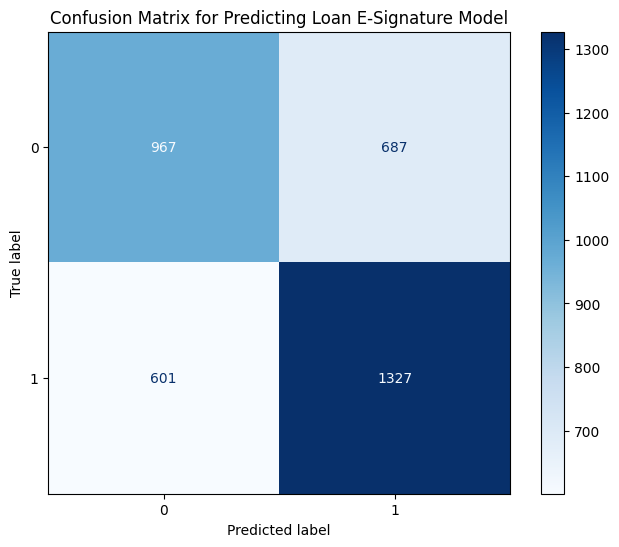

In [45]:
sklearn_confusion_matrix(y_test, y_predict)

### Receiver Operating Characteristic (ROC) Curve

AUC (Area Under the ROC Curve): 0.71


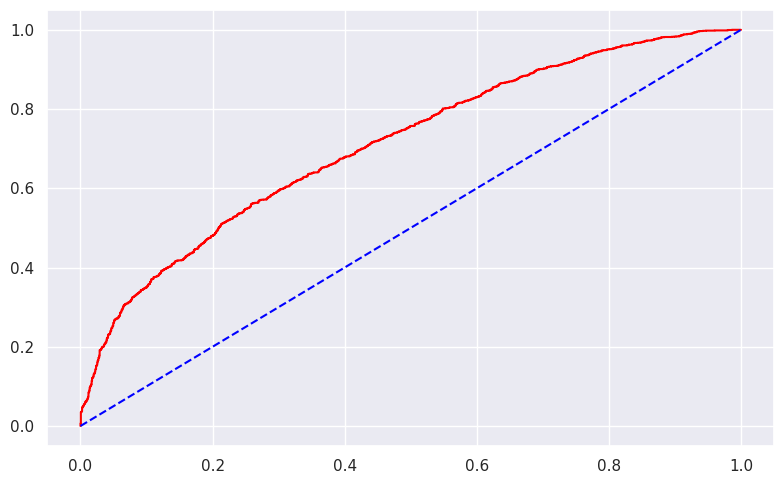

In [46]:
auc_score = plot_roc_curve(X_test, y_test, model)

We note the model's discriminatory power has improved and is considered reasonable

### Feature Significance

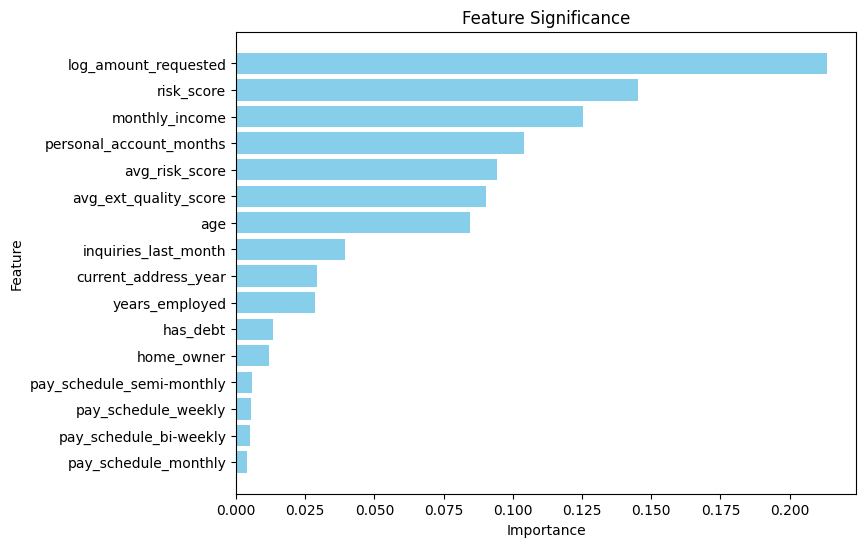

,Feature,Importance
9,log_amount_requested,0.213305
4,risk_score,0.145293
1,monthly_income,0.125284
6,personal_account_months,0.104104
7,avg_risk_score,0.094319
8,avg_ext_quality_score,0.090411
0,age,0.084380
5,inquiries_last_month,0.039487
3,current_address_year,0.029201
2,years_employed,0.028539


In [47]:
feature_df = plot_feature_significance(X_train_and_validation, model)
feature_df

## Save Model 💾

Next we use MLflow to save the optimized model along with associated metadata and artifacts

In [48]:
# Create a directory to save training sample data 
sample_dir = "../data/samples"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    
type_of_model = type(model).__name__
    
# Create a directory to save the model
model_dir = f"../models/{type_of_model}"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [49]:
import random

random_number = random.randint(10_000, 99_999)

# Use the model directory to save results
mlflow.set_tracking_uri(f'file://{os.path.abspath(model_dir)}')

# Set the experiment
experiment_name = "final_models"
mlflow.set_experiment(experiment_name)

# Save a sample of the data the model was trained on
sample_data = X_train.head()
sample_data.to_csv(f"{sample_dir}/sample_train_data_{random_number}.csv", index=False)

# Get model hyperpameters
model_params = model.get_params()
params_dict = dict(model_params)

with mlflow.start_run():
    mlflow.sklearn.log_model(model, "model")
    mlflow.log_params(params_dict)
    mlflow.log_params({"feature_importances": model.feature_importances_})
    mlflow.log_metric("accuracy", df_final_metrics["Accuracy"].values[0])
    mlflow.log_metric("precision", df_final_metrics["Precision"].values[0])
    mlflow.log_metric("recall", df_final_metrics["Recall"].values[0])
    mlflow.log_metric("F1", df_final_metrics["F1"].values[0])
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_artifact(f"{sample_dir}/sample_train_data_{random_number}.csv")

- To use the saved model for inference 🗨️

In [50]:
# Define params as desired
model_dir = "../models/GradientBoostingClassifier"
run_id = "e8c768836f1346f6b1fbd57223e1494c"

# Load the model
model = get_model(model_dir, run_id)

# Make predictions
y_predict = model.predict(X_test)

## Process Results 🔄

Here we format the final results from our model's predictions to the user this data came from. Though in the future we would not have 'e-signed' data for the deployed model's predictions, a similar process can be utilized. This enables the company to identify leads predicted not to complete the e-signature phase of the loan application process and experiment with directing them to different onboarding screens.

In [51]:
# Concatenate test labels to the user they came from
final_results_df = pd.concat([y_test, test_identifier], axis =1).dropna()

# Add predicted results from the model
final_results_df['predicted_results'] = y_predict
final_results_df = final_results_df[['entry_id', 'e_signed', 'predicted_results']].reset_index(drop=True)

# Display (adjust as needed)
final_results_df.head(10)

,entry_id,e_signed,predicted_results
0,6495937,0,1
1,2299475,1,1
2,4822403,0,0
3,7060498,1,1
4,2699789,0,0
5,4311351,1,1
6,3054334,0,0
7,5634938,1,1
8,7573188,1,0
9,7047275,1,0


### Save Data 💾

Persist final results and a list of less 'quality' applicants estimated to be unlikely to complete the loan onboarding process

In [52]:
from datetime import datetime
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table
import csv

# Create a directory to save results 
directory = "../data/results"
if not os.path.exists(directory):
    os.makedirs(directory)

# Get the current date and time, remove milliseconds
datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Save final results to a .csv file 
final_results_df.to_csv(f"../data/results/final_results_{datetime}.csv")

# Filter the DataFrame for a list of users unlikely to eSign
final_results_df = final_results_df[final_results_df.predicted_results == 0].copy()
unlikely_to_esign_df = final_results_df.copy().drop(columns = ['e_signed', 'predicted_results'])

# Save the list of users unlikely to eSign to a .csv file
unlikely_to_esign_df.to_csv(f"../data/results/users_unlikely_to_eSign_{datetime}.csv")

# Define paths to convert
csv_file = f"../data/results/users_unlikely_to_eSign_{datetime}.csv"
pdf_file = f"../data/results/users_unlikely_to_eSign_{datetime}.pdf"

# Convert the .csv file 
data = []
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        data.append(row)

# Create a PDF document
doc = SimpleDocTemplate(pdf_file, pagesize=letter)

# Create a table from the CSV data
table = Table(data)

# Add the table to the document
doc.build([table])